In [742]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [743]:
pd.set_option('display.max_rows', None)

In [744]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, classification_report

from sklearn.cluster import KMeans, AgglomerativeClustering

In [745]:
time = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\Final Capstone Project\\rio dataframes\\Outside Data\\raw\\bairros\\timeserie_energia_economia_extended.csv')

#  Data Cleaning

### TIME

In [746]:
time.dropna(how='all', inplace=True, axis=1)

In [747]:
for col in time.columns[2:]: time[col] = time[col].fillna(time[col].mean())

### FEATURES

#### Note: Repeated feature "Consumo Residencial"

#### Residential Consumption

In [762]:
bairros = time['Bairros']
cols = ['Ano', target]

In [763]:
for i in range(len(bairros.unique())): 
    
    if i==0:        
        y = time[cols][bairros==(bairros.unique()[i])]
    else:
        y = pd.merge(y, time[cols][bairros==(bairros.unique()[i])], on='Ano', how='left')

y.columns = ['Ano'] + list(bairros.unique())
y.drop(bairros.unique()[-2:], inplace=True, axis=1)

In [764]:
x_dirty = y.set_index('Ano', drop=True).T.copy()       # Contaning Data for Neighborhoods Clustering by Residential Energy Consumption only.

In [765]:
keep = []

for i in x_dirty.index:
    
    if len(i.split())>2:    
        
        if i.split()[2]=='planejamento': keep.append(False)
        else: keep.append(True)
            
    else: 
        if i=='total': keep.append(False)
        else: keep.append(True)

#### All Consumption types

In [766]:
outputs = []

for i in range(len(bairros.unique()[:-2])):
     
    bairro_df = time[targets][bairros==bairros.unique()[i]]
    
    row = []
    for i in bairro_df.index:
    
        row = row + list(bairro_df.loc[i])

    outputs.append(row)
    

In [767]:
new_x = pd.DataFrame(outputs, index=bairros.unique()[:-2])

x_dirty2 = new_x.copy()                           # Contaning Data for Neighborhoods Clustering by All Energy Consumption Types

# Feature Selection

### Note: Remember to Fill missing values with means of same neighborhood

In [768]:
out = ['total', 'região de planejamento 1.1', 'area de planejamento 2',
       'região de planejamento 2.1', 'região de planejamento 2.2',
       'area de planejamento 3', 'região de planejamento 3.1',
       'região de planejamento 3.2', 'região de planejamento 3.3',
       'região de planejamento 3.4']

In [769]:
targets = ['Consumo de energia elétrica (MWh)', 'Residencial_x',        # Energy related variables
       'Industrial_x', 'Comercial', 'Rural_x', 'Poder público ',
       'Iluminacão pública', 'Serv.público_x', 'Consumo próprio_x',
       'Consumo resdencial de energia elétrica (MWh)',
       'Médio anual por unidade consumidora  ',
       'Total de unidades consumidoras  residenciais ', 'Total_y.1',
       'Residencial_y', 'Industrial_y', 'Comercial ', 'Rural_y',
       'Poderes públicos ', 'Iluminação pública', 'Serv.público_y',
       'Consumo próprio_y']

In [770]:
i=-1

In [772]:
i+=1
target = targets[i]
print(i, target)

1 Residencial_x


## X & Y Selection:

In [759]:
x1 = x_dirty[[i for i in keep]]

In [760]:
x = x_dirty2[[i for i in keep]]

In [775]:
x=x1.copy()    # Residencial

In [776]:
x.shape, x1.shape

((70, 13), (70, 13))

# Log Transformation

In [777]:
x = x.apply(np.log1p)

In [778]:
#sns.distplot(x[2017], kde=False, bins=80)

# Normalization

In [779]:
scaler = MinMaxScaler()
x_norm = scaler.fit_transform(x)

In [780]:
#scaler = StandardScaler()
#x_norm = scaler.fit_transform(x)

# K Means Clustering

## Optimizing Number of Cluster

In [781]:
inits=['k-means++', 'random']
algs = ['auto', 'full', 'elkan']

In [782]:
inertias = []
for i in range(1, 50):
    
    kmeans = KMeans(n_clusters=i, init=inits[0], n_init=30, max_iter=500, algorithm=algs[0]).fit(x_norm)
    
    inertias.append([i, kmeans.n_iter_, kmeans.inertia_])
    if i in range(1, 100, 5): print(i)

1
6
11
16
21
26
31
36
41
46


In [783]:
inertia_df = pd.DataFrame(inertias, columns=['n clusters', 'n iter', 'inertia'])

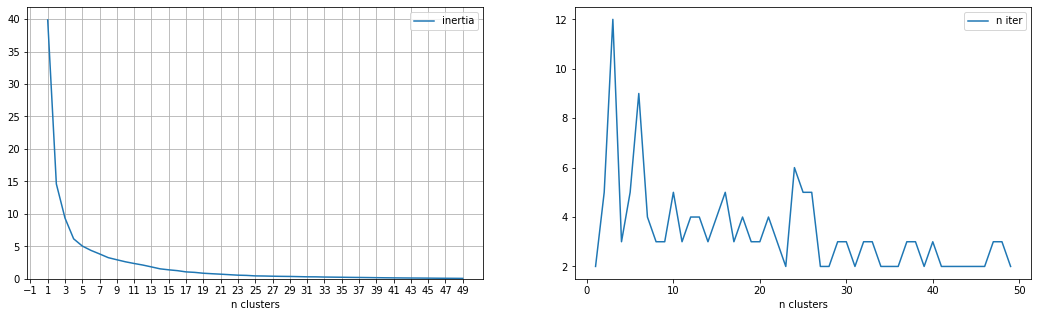

In [787]:
fig = plt.figure(figsize=(18,5))

ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
u = np.linspace(0, 100, 21)
v = np.linspace(0, 100, 21)

inertia_df.plot(x='n clusters', y='inertia', ax=ax0, ylim=(0), xticks=np.arange(-1, 50, 2))
#ax0.plot(u, u*0)
ax0.grid()
inertia_df.plot(x='n clusters', y='n iter', ax=ax1)

##  Modeling

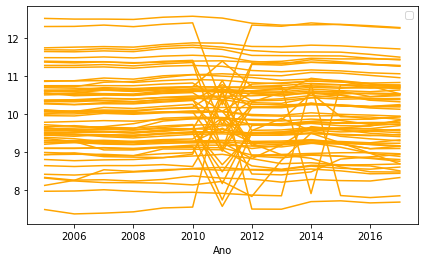

In [788]:
x.T.plot(figsize=(7,4), color='orange')
plt.legend('')
plt.show()

In [789]:
kmeans = KMeans(n_clusters=int(input()), init=inits[0], n_init=30, max_iter=1000, algorithm=algs[0]).fit(x_norm)

print('Iterations:', kmeans.n_iter_, 'Inertia:', kmeans.inertia_)

x['cluster'] = kmeans.labels_

n_clusters = kmeans.n_clusters

 5


Iterations: 5 Inertia: 5.048811023863838


## Visualizing Generetaed Clusters

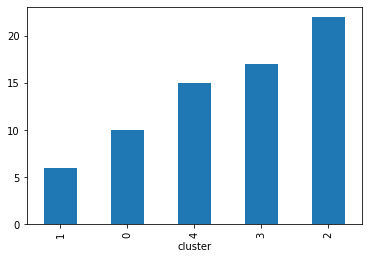

In [790]:
x.groupby('cluster').count().iloc[:, 0].sort_values(ascending=True).plot(kind='bar')

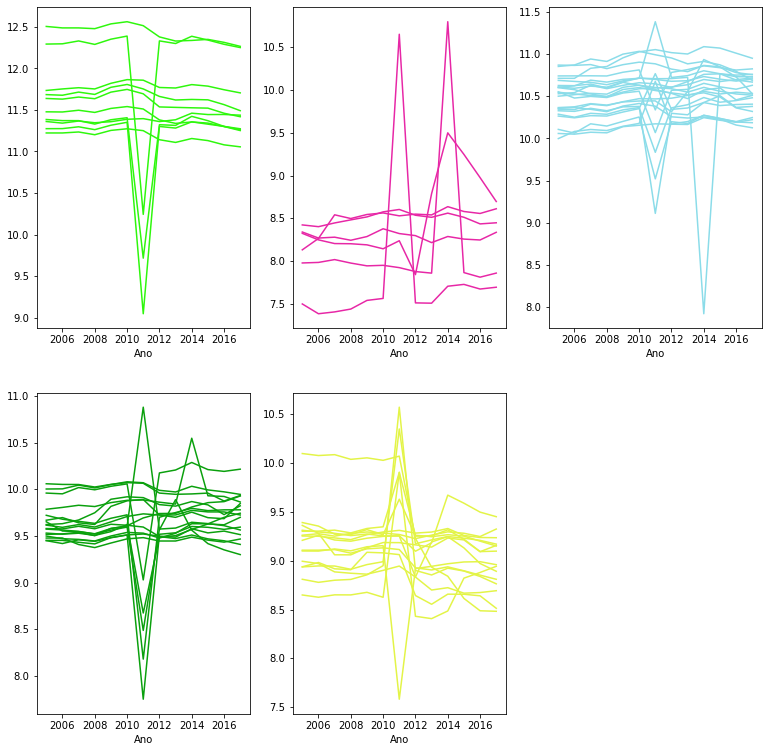

In [791]:
fig = plt.figure(figsize=(13,13))

axes = [fig.add_subplot((int(n_clusters/3)+1 if n_clusters//3!=0 else n_clusters/3), 3, i) for i in range(1, n_clusters+1)]

for i in range(n_clusters):
    
    #filt = time_cluster[time_cluster[target]<4e4]
    rgb = np.random.rand(3,)
    x[x['cluster']==i].T.drop('cluster').plot(color=[rgb], legend='', ax=axes[i])

plt.show()

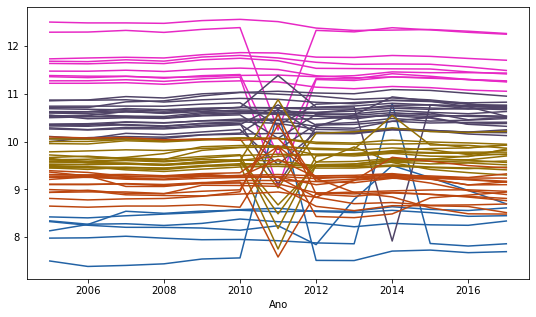

In [794]:
fig = plt.figure(figsize=(9,5))
ax0 = fig.add_subplot(111)

for i in range(n_clusters):
    
    #filt = time_cluster[time_cluster[target]<4e4]
    rgb = np.random.rand(3,)
    x[x['cluster']==i].T.drop('cluster').plot(color=[rgb], legend='', ax=ax0)

plt.show()

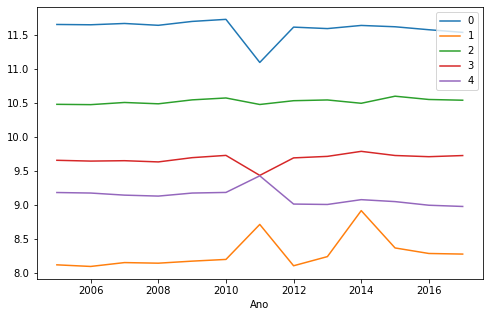

In [807]:
x_grps = x.groupby('cluster').mean()

fig = plt.figure(figsize=(8,5))
ax0 = fig.add_subplot(111)

x_grps.T.plot(ax=ax0)

ax0.legend(loc='upper right')

# Pair Plot

In [726]:
vis = time[~time.Bairros.isin(out)][['Bairros']+targets]

In [727]:
x_bairros = x.reset_index().rename(columns={'index':'Bairros'})[['Bairros', 'cluster']]

In [734]:
energy = pd.merge(vis, x_bairros, on='Bairros')

In [735]:
energy.iloc[:, :10].head(2)

,Bairros,Consumo de energia elétrica (MWh),Residencial_x,Industrial_x,Comercial,Rural_x,Poder público,Iluminacão pública,Serv.público_x,Consumo próprio_x
0,saude,81124.219,1805.529,32128.535,30962.243,0.0,15434.712,0.0,1.2,792.0
1,saude,76264.387,1610.220,34035.716,24390.539,0.0,15434.712,0.0,1.2,792.0


In [739]:
energy.head()

,Bairros,Consumo de energia elétrica (MWh),Residencial_x,Industrial_x,Comercial,Rural_x,Poder público,Iluminacão pública,Serv.público_x,Consumo próprio_x,...,Total_y.1,Residencial_y,Industrial_y,Comercial,Rural_y,Poderes públicos,Iluminação pública,Serv.público_y,Consumo próprio_y,cluster
0,saude,81124.219,1805.529,32128.535,30962.243,0.0,15434.712,0.0,1.2,792.0,...,1366.0,811.0,10.0,523.0,0.0,18.0,0.0,3.0,1.0,3
1,saude,76264.387,1610.220,34035.716,24390.539,0.0,15434.712,0.0,1.2,792.0,...,1481.0,875.0,10.0,579.0,0.0,17.0,0.0,0.0,0.0,3
2,saude,74329.304,1645.057,31786.307,20632.245,0.0,20265.695,0.0,0.0,0.0,...,1493.0,892.0,7.0,576.0,0.0,18.0,0.0,0.0,0.0,3
3,saude,67900.939,1700.901,28126.070,19498.250,0.0,18575.718,0.0,0.0,0.0,...,1488.0,884.0,7.0,576.0,0.0,21.0,0.0,0.0,0.0,3
4,saude,69343.963,1881.956,26832.188,19977.777,0.0,20652.042,0.0,0.0,0.0,...,1741.0,893.0,7.0,816.0,0.0,24.0,0.0,1.0,0.0,3


C:\Users\luisr\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\luisr\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\luisr\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\luisr\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\luisr\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\luisr\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Defa

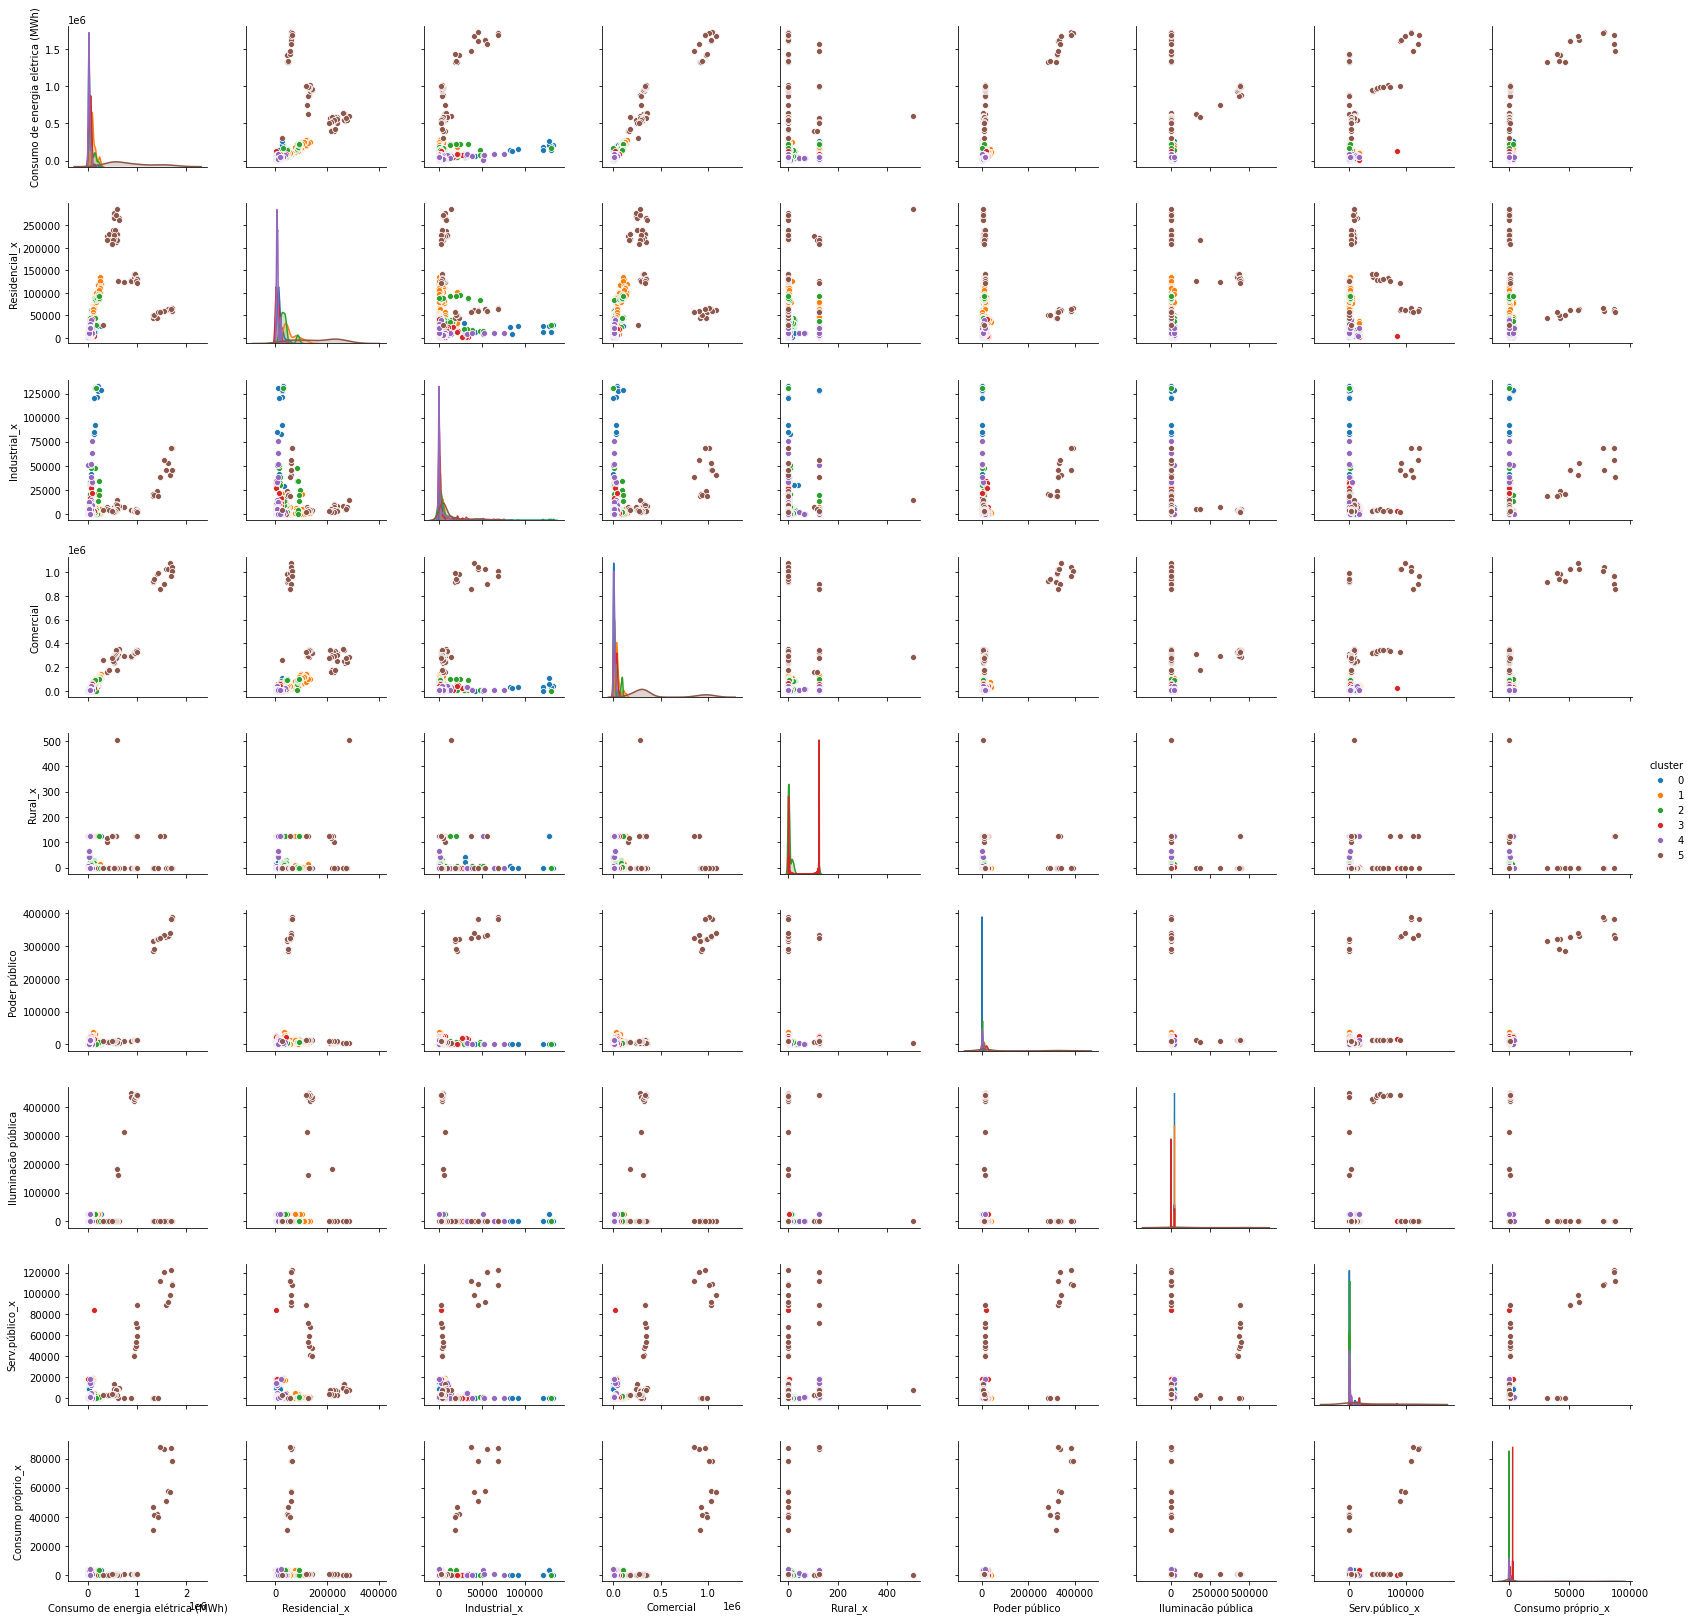

In [740]:
sns.pairplot(energy.iloc[:, list(range(10))+[-1]], hue='cluster')

## Agglomerative Clustering

### Optimization

### Note: Append accuracy as well. Try to plot out 'n clusters', 'threshold', and 'accuracy' relationships.

In [795]:
n_clus=[]
for i in range(1, 1001):
    
    agg = AgglomerativeClustering(n_clusters=None,
                              affinity=aff[0],
                              compute_full_tree='auto',
                              linkage=link[0],
                              distance_threshold=i/20)
    agg.fit(x_norm)
    n_clus.append([i/20, agg.n_clusters_])

    if i in range(1, 101, 10): print('Leaves:',agg.n_leaves_, 'Connected components:', agg.n_connected_components_, 'clusters:', agg.n_clusters_)

Leaves: 70 Connected components: 1 clusters: 66
Leaves: 70 Connected components: 1 clusters: 16
Leaves: 70 Connected components: 1 clusters: 7
Leaves: 70 Connected components: 1 clusters: 4
Leaves: 70 Connected components: 1 clusters: 4
Leaves: 70 Connected components: 1 clusters: 3
Leaves: 70 Connected components: 1 clusters: 3
Leaves: 70 Connected components: 1 clusters: 2
Leaves: 70 Connected components: 1 clusters: 2
Leaves: 70 Connected components: 1 clusters: 2


In [796]:
clus_df = pd.DataFrame(n_clus, columns=['Threshold', 'Clusters'])

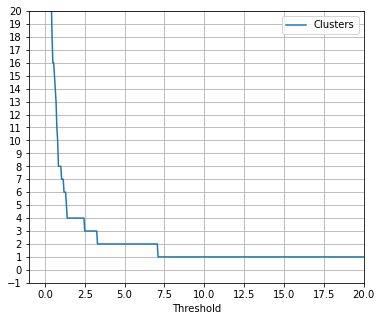

In [805]:
clus_df.plot('Threshold', 'Clusters', figsize=(6,5), yticks=np.arange(-1, 60, 1), xlim=(-1,20), ylim=(-1,20))
plt.grid()

### Modeling

In [409]:
aff = ["euclidean", "l1", "l2", "manhattan", "cosine", "precomputed"]

link = ["ward", "complete", "average", "single"]


In [410]:
agg = AgglomerativeClustering(n_clusters=int(input()),
                              affinity=aff[0],
                              compute_full_tree='auto',
                              linkage=link[0],
                              distance_threshold=None)
agg.fit(x_norm)

x['cluster'] = agg.labels_
n_clusters = agg.n_clusters_

print('Leaves:',agg.n_leaves_, 'Connected components:', agg.n_connected_components_, 'clusters:', n_clusters)

 10


Leaves: 70 Connected components: 1 clusters: 10


##  Clusters Visualization

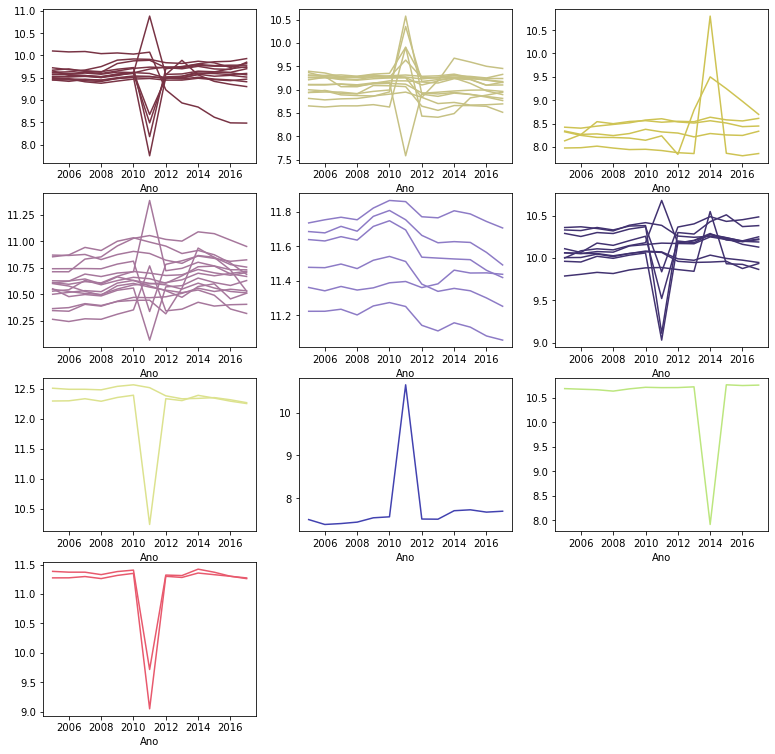

In [411]:
fig = plt.figure(figsize=(13,13))

axes = [fig.add_subplot((int(n_clusters/3)+1 if n_clusters//3!=0 else n_clusters/3), 3, i) for i in range(1, n_clusters+1)]

for i in range(n_clusters):
    
    #filt = time_cluster[time_cluster[target]<4e4]
    rgb = np.random.rand(3,)
    x[x['cluster']==i].T.drop('cluster').plot(color=[rgb], legend='', ax=axes[i])

plt.show()

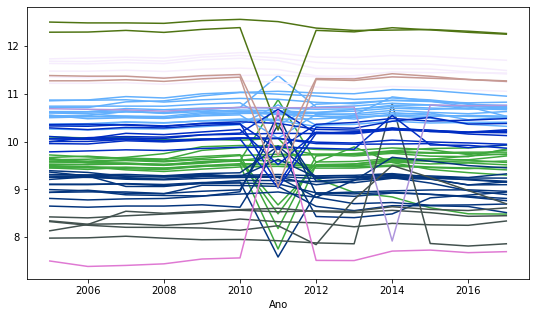

In [412]:
fig = plt.figure(figsize=(9,5))
ax0 = fig.add_subplot(111)

for i in range(n_clusters):
    
    #filt = time_cluster[time_cluster[target]<4e4]
    rgb = np.random.rand(3,)
    x[x['cluster']==i].T.drop('cluster').plot(color=[rgb], legend='', ax=ax0)

plt.show()

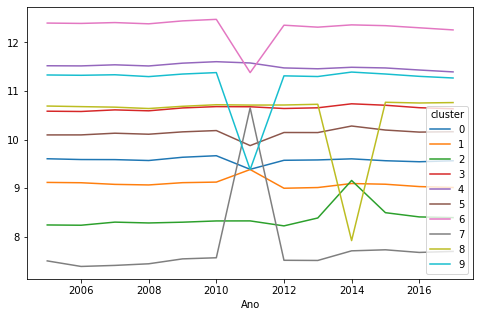

In [413]:
x_grps = x.groupby('cluster').mean()

fig = plt.figure(figsize=(8,5))
ax0 = fig.add_subplot(111)

x_grps.T.plot(ax=ax0)

# Clustering Neighborhoods by Energy Consumption Pattern.